In [9]:
import numpy as np
import pandas as pd
import json
import collections
from collections import defaultdict 
from functools import partial
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# project_dir = '/home/am8520/GP/MIMIC-SNONET'
# mimic_dir = '/home/am8520/GP/MIMIC-SNONET/RAW'

project_dir = '/home/asem/GP/MIMIC-SNONET'
mimic_dir = '/home/asem/GP/ehr-data/mimic3-v1.4/physionet.org/files/mimiciii/1.4'


In [13]:
# Good read: https://iq-inc.com/importerror-attempted-relative-import/

import sys
import importlib


from mimicnet import dag

importlib.reload(sys.modules['mimicnet.dag'])

<module 'mimicnet.dag' from '/home/asem/GP/MIMIC-SNONET/mimicnet/dag.py'>

In [14]:
x = dag.CCSDAG()

In [18]:
DIAGNOSES_ICD = pd.read_csv(f'{mimic_dir}/DIAGNOSES_ICD.csv.gz')
PROCEDURES_ICD = pd.read_csv(f'{mimic_dir}/PROCEDURES_ICD.csv.gz')


PATIENTS = pd.read_csv(f'{mimic_dir}/PATIENTS.csv.gz')

LABEVENTS = pd.read_csv(f'{mimic_dir}/LABEVENTS.csv.gz')
CHARTEVENTS = pd.read_csv(f'{mimic_dir}/CHARTEVENTS.csv.gz')

FileNotFoundError: [Errno 2] No such file or directory: '/home/asem/GP/ehr-data/mimic3-v1.4/physionet.org/files/mimiciii/1.4/CHAREVENTS.csv.gz'

In [17]:
DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


### Notes

#### TODO

1. From DIAGNOSES_ICD:
    - map to CCS (multi/single)
    - histogram of diseases (number of patients for each CCS code)
2. From ADMISSION and ICUSTAY:
    - #Admissions per patient
    - #ICUStays per patient
    - #ICUStays per admission
3. measurements: merge all measurements by HADM_ID (aggregate by median).

In [19]:

ADMISSIONS = pd.read_csv(f'{mimic_dir}/ADMISSIONS.csv.gz')
ICUSTAYS = pd.read_csv(f'{mimic_dir}/ICUSTAYS.csv.gz')

In [20]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [34]:
patients_admission = defaultdict(set)

for row in ADMISSIONS.itertuples():
    patients_admission[row.SUBJECT_ID].add(row.HADM_ID)
    
patients_admission_df = pd.DataFrame({'patient': patients_admission.keys(), 'n_admissions': map(len, patients_admission.values())})

In [35]:
patients_admission_df

,patient,n_admissions
0,22,1
1,23,2
2,24,1
3,25,1
4,26,1
...,...,...
46515,98794,1
46516,98797,1
46517,98800,1
46518,98802,1


<AxesSubplot:xlabel='n_admissions', ylabel='Count'>

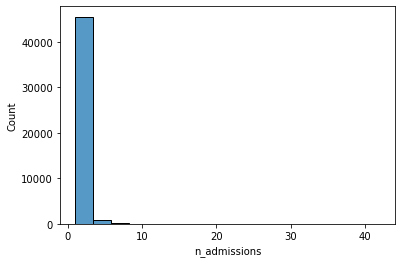

In [36]:
sns.histplot(data=patients_admission_df, x="n_admissions")


In [45]:
np.sum(patients_admission_df.n_admissions == 0)

0

In [24]:
patients_admission_count = list(map(lambda t: (t[0], len(t[1])), patients_admission.items()))

In [28]:
_, counts = zip(*patients_admission_count)

In [30]:
admissions_hist = np.histogram(counts)

In [31]:
admissions_hist

(array([46239,   221,    40,    10,     3,     3,     0,     1,     2,
            1]),
 array([ 1. ,  5.1,  9.2, 13.3, 17.4, 21.5, 25.6, 29.7, 33.8, 37.9, 42. ]))